# An ANN model to predict the Iris species

The Iris data set is one of the classical datasets used as an introduction
to machine learning.  It was introduced by [Sir Ronald Aylmer Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher) (statistician and
biologist) in his 1936 paper "The use of multiple measurements in taxonomic
problems".  Consists of 150 samples, 50 for each species of the Iries
flower, named setosa, virginica and versicolor while for each sample
we meanure the length and width of the sepals and the petals.

The objective of the model we are creating here is to develop a model that 
will predict the species from the corresponing measurements.



<table>
<tr>
<th style="text-align:center">setosa</th>
<th style="text-align:center">virginica</th>
    <th style="text-align:center">versicolor</th>
</tr>
<tr>
<td><img src="./images/setosa.jpg" style="width:220px;height:220px"/></td>
<td><img src="./images/virginica.jpg" style="width:220px;height:220px"/></td>
<td><img src="./images/versicolor.jpg" style="width:220px;height:220px"/></td>
</tr>
</table>

[Ronald Fisher original paper](./data/iris-fisher.pdf)


In [4]:
from IPython.display import IFrame
IFrame("./data/iris-fisher.pdf", width="100%", height=600)

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import to_categorical
import numpy as np

In [6]:
# Load the data and randomize them.
df = pd.read_csv("./data/iris-dataset.csv")
df = df.sample(frac=1)

# Enrich the data adding a numeric column to represent the species.
species_index = { n: i for i, n in enumerate(np.unique(df["Species"]))}
df["si"] = df.apply(lambda row: species_index[row["Species"]], axis=1)
df

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,si
16,17,5.4,3.9,1.3,0.4,setosa,0
78,79,6.0,2.9,4.5,1.5,versicolor,1
14,15,5.8,4.0,1.2,0.2,setosa,0
43,44,5.0,3.5,1.6,0.6,setosa,0
55,56,5.7,2.8,4.5,1.3,versicolor,1
...,...,...,...,...,...,...,...
96,97,5.7,2.9,4.2,1.3,versicolor,1
109,110,7.2,3.6,6.1,2.5,virginica,2
89,90,5.5,2.5,4.0,1.3,versicolor,1
8,9,4.4,2.9,1.4,0.2,setosa,0


### Check the composition of the data 

We can see that in our sample we have an equal number of 
each of the species:

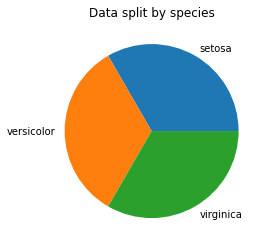

In [7]:
counters = [len(df[df["Species"] == species]) for species in df['Species'].unique()]
_ = plt.pie(counters, labels=df['Species'].unique())
_ = plt.title("Data split by species")

### Preview the Data

Our first step when we have to deal with data is to visualize them
and improve our intutive understanding of them.

The following scatter represenation gives us a hint of how the dataset
is clustered in terms of the sepal length-width in a by species basis:

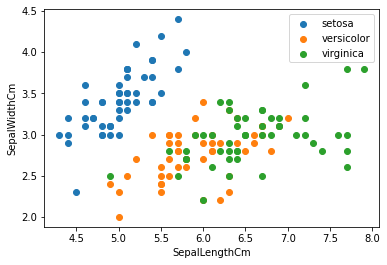

In [17]:
for species in df['Species'].unique():
    df1 = df[df['Species'] == species]
    plt.scatter(
        df1["SepalLengthCm"], df1["SepalWidthCm"], label=species
    )
_ = plt.legend()   
_ = plt.xlabel("SepalLengthCm")
_ = plt.ylabel("SepalWidthCm")


### Separate data to training and testing subsets

We are splitting the available data into two completely distict
subsets:

#### Training Data

The training data will be used to traing the NN meaning to fit
the curve to them with the minimum possible loss.
    
#### Testing Data

The testing data are compoletely separate from the testing and
are never be seem from the training phase; they are used after
the training process to verify the accurary of the model in
unseen data.


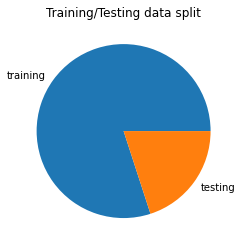

In [18]:
# Break down to testing and training data.
training_data = df.iloc[:120]
testing_data = df.iloc[120:]

_ = plt.pie([len(training_data), len(testing_data)], labels = ["training", "testing"])
_ = plt.title("Training/Testing data split")

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
input_cols = ["SepalLengthCm","SepalWidthCm","PetalLengthCm","PetalWidthCm"]
X = training_data[input_cols].copy()
Y = pd.DataFrame(training_data["si"].copy())

### Split the training data to train and validation subsets

To avoid overfitting our model to the training data, we are extracting
from them a portion that we call **validation dataset** which will be used
during the training process as an "implicit" test (still not the test we
will do after the training is complete but as an intermediate testing).

In [21]:
train_X, validation_x, train_y, validation_y = train_test_split(X, Y, test_size=0.3, stratify=Y)

### Convert numerical to categorical values

The name of the species is given as a "free" text (like setosa for example). The way 
to present this type of **nominal** data is to convert them to **categorical**.  This
trick is as simple as creating an array of **N** binary numbers (where N is the number of options).

So, in our case since we have three **nominal** values we can represent any of them as an instance of 
a three dimentional array as can be seen here:


| Name        | category    |
| ----------- | ----------- |
| setosa      | $[1, 0, 0]$ |
| virginica   | $[0, 1, 0]$ |
| versicolor  | $[0, 0, 1]$ |

We have added the **si** (species index) column just to make things easier for our 
conversion (it represents an arbitrary correspondance from species name to a numeric
value just because it is easier to handle).

To keep things simple, we use the *to_categorical* function which receives an array of
**scalars** and returns an array of arrays each one representing the nomimal value
as an array.


In [22]:
train_y = to_categorical(train_y)
validation_y = to_categorical(validation_y)

### Buidling the neural network

The shaped of the NN that we will use can be thought as similar to the following:

<img src="./images/iris-nn-example.png" style="width:520px"/>

The input to the NN consist of the 4 measurements for petal and sepal lentgh and width (later 
we will see that we will need yet another one that we will call bias and always will have the 
value of 1).

The output of the NN consist of 3 values that we will try to match with the observed 
values.  For example by convention we can use the value vector $[1, 0,  0 ]$ to *setosa*.


In [26]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(4),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [37]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 100)               500       
                                                                 
 dense_7 (Dense)             (None, 3)                 303       
                                                                 
Total params: 803
Trainable params: 803
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
history = model.fit(train_X, train_y, batch_size=12, epochs=10, validation_data=(validation_x, validation_y), verbose=1)

Epoch 1/10
7/7 [==============================] - 1s 31ms/step - loss: 0.9717 - accuracy: 0.4881 - val_loss: 0.6668 - val_accuracy: 0.6667
Epoch 2/10
1/7 [===>..........................] - ETA: 0s - loss: 0.6528 - accuracy: 0.6667

2022-09-06 10:16:48.312310: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


7/7 [==============================] - 0s 5ms/step - loss: 0.5723 - accuracy: 0.7262 - val_loss: 0.4922 - val_accuracy: 0.7222
Epoch 3/10
7/7 [==============================] - 0s 5ms/step - loss: 0.4438 - accuracy: 0.8333 - val_loss: 0.4023 - val_accuracy: 0.7500
Epoch 4/10
7/7 [==============================] - 0s 5ms/step - loss: 0.3959 - accuracy: 0.8690 - val_loss: 0.3571 - val_accuracy: 0.8611
Epoch 5/10
7/7 [==============================] - 0s 5ms/step - loss: 0.3379 - accuracy: 0.8571 - val_loss: 0.3727 - val_accuracy: 0.7500
Epoch 6/10
7/7 [==============================] - 0s 5ms/step - loss: 0.3100 - accuracy: 0.8690 - val_loss: 0.2744 - val_accuracy: 0.9722
Epoch 7/10
7/7 [==============================] - 0s 5ms/step - loss: 0.2668 - accuracy: 0.9405 - val_loss: 0.2380 - val_accuracy: 0.9722
Epoch 8/10
7/7 [==============================] - 0s 5ms/step - loss: 0.2383 - accuracy: 0.9643 - val_loss: 0.2188 - val_accuracy: 0.9722
Epoch 9/10
7/7 [=============================

### Visualize the training phase

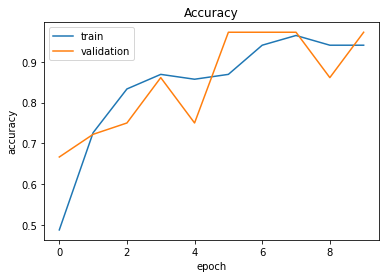

In [29]:
#Accuracy plot
plt.figure()
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()


### Check accuracy on unseen data

In [30]:
testing_data

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,si
60,61,5.0,2.0,3.5,1.0,versicolor,1
124,125,6.7,3.3,5.7,2.1,virginica,2
145,146,6.7,3.0,5.2,2.3,virginica,2
142,143,5.8,2.7,5.1,1.9,virginica,2
85,86,6.0,3.4,4.5,1.6,versicolor,1
27,28,5.2,3.5,1.5,0.2,setosa,0
113,114,5.7,2.5,5.0,2.0,virginica,2
148,149,6.2,3.4,5.4,2.3,virginica,2
123,124,6.3,2.7,4.9,1.8,virginica,2
104,105,6.5,3.0,5.8,2.2,virginica,2


Number of testing samples: x: 30 y: 30
1/1 [==============================] - 0s 125ms/step - loss: 0.2318 - accuracy: 0.9333
Accuracy:   0.9333


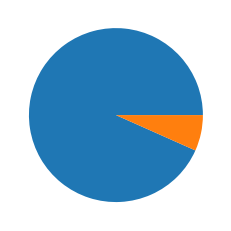

In [31]:
testing_X = testing_data[input_cols].copy()
testing_Y = pd.DataFrame(testing_data["si"].copy())
testing_Y = to_categorical(testing_Y)

print(f"Number of testing samples: x: {len(testing_X)} y: {len(testing_Y)}")


test_loss, test_acc = model.evaluate(testing_X, testing_Y)
print(f'Accuracy: {test_acc:8.4}')
_ = plt.pie([test_acc, 1 - test_acc])

### Make adhoc prediction to unseen data 

In [32]:
x = model.predict([[54, 5.5, 2.3, 4.0]])
x1, x2, x3 = x[0]

print(round(x1), round(x2), round(x3))

1/1 [==============================] - 0s 87ms/step
1 0 0


In [33]:
# Manually predicting all the testing data (just to make 
# things easier to understand).

print(len(testing_data))

def get_index_from_category(d):
    current_value = -1
    current_index = None
    for index, value in enumerate(d):
        if value >= current_value:
            current_value = value
            current_index =  index
    return current_index

correct, wrong = 0, 0
for index, row in testing_data.iterrows():
    expected = row["si"]
    predicted = model.predict(
    [
        [row["SepalLengthCm"], row["SepalWidthCm"], row["PetalLengthCm"], row["PetalWidthCm"]]
    ]
    )
    j = get_index_from_category(predicted[0])
    print(row["SepalLengthCm"], row["SepalWidthCm"], row["PetalLengthCm"], row["PetalWidthCm"], expected, j)
    
    if expected == j:
        correct += 1
    else:
        wrong += 1
        
print (f"Correct: {correct} Wrong: {wrong}")
    

30
1/1 [==============================] - 0s 36ms/step
5.0 2.0 3.5 1.0 1 1
1/1 [==============================] - 0s 28ms/step
6.7 3.3 5.7 2.1 2 2
1/1 [==============================] - 0s 27ms/step
6.7 3.0 5.2 2.3 2 2
1/1 [==============================] - 0s 28ms/step
5.8 2.7 5.1 1.9 2 2
1/1 [==============================] - 0s 26ms/step
6.0 3.4 4.5 1.6 1 1
1/1 [==============================] - 0s 27ms/step
5.2 3.5 1.5 0.2 0 0
1/1 [==============================] - 0s 27ms/step
5.7 2.5 5.0 2.0 2 2
1/1 [==============================] - 0s 26ms/step
6.2 3.4 5.4 2.3 2 2
1/1 [==============================] - 0s 26ms/step
6.3 2.7 4.9 1.8 2 2
1/1 [==============================] - 0s 26ms/step
6.5 3.0 5.8 2.2 2 2
1/1 [==============================] - 0s 26ms/step
6.5 3.2 5.1 2.0 2 2
1/1 [==============================] - 0s 25ms/step
6.7 3.0 5.0 1.7 1 2
1/1 [==============================] - 0s 25ms/step
5.1 3.3 1.7 0.5 0 0
1/1 [==============================] - 0s 26ms/step
6.1 2.8 4

In [34]:
print(len(training_data))

def get_index_from_category(d):
    current_value = -1
    current_index = None
    for index, value in enumerate(d):
        if value >= current_value:
            current_value = value
            current_index =  index
    return current_index

    
for index, row in training_data.iterrows():
    expected = row["si"]
    predicted = model.predict(
    [
        [row["SepalLengthCm"], row["SepalWidthCm"], row["PetalLengthCm"], row["PetalWidthCm"]]
    ]
    )
    j = get_index_from_category(predicted[0])
    print(row["SepalLengthCm"], row["SepalWidthCm"], row["PetalLengthCm"], row["PetalWidthCm"], expected, j)

120
1/1 [==============================] - 0s 33ms/step
5.4 3.9 1.3 0.4 0 0
1/1 [==============================] - 0s 27ms/step
6.0 2.9 4.5 1.5 1 1
1/1 [==============================] - 0s 27ms/step
5.8 4.0 1.2 0.2 0 0
1/1 [==============================] - 0s 27ms/step
5.0 3.5 1.6 0.6 0 0
1/1 [==============================] - 0s 29ms/step
5.7 2.8 4.5 1.3 1 1
1/1 [==============================] - 0s 28ms/step
6.0 2.2 4.0 1.0 1 1
1/1 [==============================] - 0s 25ms/step
5.1 3.8 1.5 0.3 0 0
1/1 [==============================] - 0s 25ms/step
5.5 3.5 1.3 0.2 0 0
1/1 [==============================] - 0s 27ms/step
4.3 3.0 1.1 0.1 0 0
1/1 [==============================] - 0s 27ms/step
6.9 3.1 5.1 2.3 2 2
1/1 [==============================] - 0s 27ms/step
6.1 3.0 4.6 1.4 1 1
1/1 [==============================] - 0s 25ms/step
5.0 3.4 1.6 0.4 0 0
1/1 [==============================] - 0s 26ms/step
5.6 2.7 4.2 1.3 1 1
1/1 [==============================] - 0s 26ms/step
6.2 2.9 

1/1 [==============================] - 0s 26ms/step
4.4 3.0 1.3 0.2 0 0
1/1 [==============================] - 0s 25ms/step
5.9 3.0 4.2 1.5 1 1
1/1 [==============================] - 0s 24ms/step
5.5 2.4 3.8 1.1 1 1
1/1 [==============================] - 0s 26ms/step
5.4 3.9 1.7 0.4 0 0
1/1 [==============================] - 0s 25ms/step
6.0 2.2 5.0 1.5 2 2
1/1 [==============================] - 0s 26ms/step
5.0 3.3 1.4 0.2 0 0
